In [ ]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [685]:
from sparselinear import SparseLinear

In [686]:
import neural_lib as nl

In [687]:
import numpy as np
import pandas as pd

In [4]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

In [5]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [183]:
df = pd.read_csv('Stars.csv')
df.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


# Pipeline

# Step 0. Binarize the data

In [491]:
def bin_less(bin):
  return [True]*bin[0] + [False]*(5-bin[0])


def binarize_by_bin(df,col_name,bins):
  
  which_bin = np.digitize(np.array(df[col_name]).reshape(-1, 1), bins=bins)
  X_binned = np.apply_along_axis(bin_less,1, which_bin)

  return pd.DataFrame(X_binned,columns = [ '>' + str(bin) for bin in bins])

In [492]:
Temp = binarize_by_bin(df,'Temperature',[3700, 5200, 6000,7500,10000])


In [493]:
Lum = binarize_by_bin(df,'L',[0.08, 0.6, 1.5, 5, 25])

In [494]:
Rad = binarize_by_bin(df,'R',[0.7, 0.96, 1.15, 1.4, 1.8])

In [546]:
from sklearn.preprocessing import OneHotEncoder

def binarize_cat(df,col_name):
  encoder = OneHotEncoder(sparse_output=False,min_frequency=0.12)
  b = encoder.fit_transform(df[col_name].to_numpy().reshape(-1,1))
  b = np.apply_along_axis(lambda x: np.where(x==1, True, False),1,b)
  return pd.DataFrame(b,columns = [ col_name[0]+ '_' + bin[3:] for bin in encoder.get_feature_names_out()])

In [551]:
SpCl = binarize_cat(df,'Spectral_Class').rename(columns={'S_infrequent_sklearn':'S_oth'})
Clr = binarize_cat(df,'Color').rename(columns={'C_infrequent_sklearn':'C_Yel'})

In [552]:
Type = pd.DataFrame(df.apply(lambda x: True if int(x.Type)>2 else False, axis=1))

In [596]:
df_bin = pd.concat([Temp, Rad,Clr, Type], axis=1)
df_bin.index = [str(x) for x in df_bin.index.tolist()]
df_bin = df_bin.rename(columns={0:'y'})

In [597]:
df_bin

,>3700,>5200,>6000,>7500,>10000,>0.7,>0.96,>1.15,>1.4,>1.8,C_Blue,C_Red,C_Yel,y
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,True,True,True,True,True,True,True,True,True,True,True,False,False,True
236,True,True,True,True,True,True,True,True,True,True,True,False,False,True
237,True,True,True,True,False,True,True,True,True,True,False,False,True,True
238,True,True,True,True,False,True,True,True,True,True,False,False,True,True


Split the data to train and test

In [598]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_bin.drop(columns=['y']), df_bin['y'], test_size=0.33, random_state=42)

## Step 1. Build Monotone Concept Lattice


Put binarized data in FormalContext and compute monotone ConceptLattice

In [599]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (160 objects, 13 attributes, 934 connections)
   |>3700|>5200|>6000|>7500|>10000|...|>1.4|>1.8|C_Blue|C_Red|C_Yel|
97 |    X|    X|    X|    X|      |...|    |    |      |     |    X|
65 |     |     |     |     |      |...|    |    |      |    X|     |
212|    X|    X|    X|    X|     X|...|   X|   X|      |     |    X|
208|    X|    X|    X|    X|     X|...|    |    |     X|     |     |
142|    X|    X|    X|    X|     X|...|    |    |     X|     |     |
31 |    X|    X|    X|    X|     X|...|   X|   X|      |     |    X|
12 |     |     |     |     |      |...|    |    |      |    X|     |
35 |    X|    X|    X|    X|      |...|   X|   X|      |     |    X|
28 |    X|    X|    X|    X|     X|...|    |    |      |     |    X|
42 |     |     |     |     |      |...|   X|   X|      |    X|     |
....................................................................
....................................................................
121|     |     |     |     |      |...|    

In [600]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

70

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [663]:
from sklearn.metrics import f1_score, accuracy_score, log_loss, roc_auc_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures['accuracy_score'] = accuracy_score(y_train, y_preds)
    c.measures['log_loss'] = log_loss(y_train, y_preds)
    c.measures['roc_auc_score'] = log_loss(y_train, y_preds)


Select indices of the best concepts from the lattice

In [689]:
for score in ['f1_score', 'accuracy_score', 'log_loss', 'roc_auc_score']:
  best_concepts = list(L.measures[score].argsort()[::-1])
  i = 70
  while len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects:
    i -=1
    best_concepts = list(L.measures[score].argsort()[::-1][:i])
    
  print(str(i+1) + ' concepts with ' + score)

23 concepts with f1_score
28 concepts with accuracy_score
3 concepts with log_loss
3 concepts with roc_auc_score


In [666]:
best_concepts = list(L.measures['accuracy_score'].argsort()[::-1])
i = 70
while len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects:
  i -=1
  best_concepts = list(L.measures['accuracy_score'].argsort()[::-1][:i])
i+1

28

In [667]:
best_concepts = list(L.measures['log_loss'].argsort()[::-1])
i = 70
while len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects:
  i -=1
  best_concepts = list(L.measures['log_loss'].argsort()[::-1][:i])
  
i+1

3

In [669]:
best_concepts = list(L.measures['roc_auc_score'].argsort()[::-1])
i = 70
while len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects:
  i -=1
  best_concepts = list(L.measures['roc_auc_score'].argsort()[::-1][:i])
  
i+1

3

In [670]:
best_concepts = list(L.measures['roc_auc_score'].argsort()[::-1][:i+1])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"


Construct neural network based on concept lattice

In [671]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [672]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

Move the nodes in visualization to make it look pretty

In [673]:
vis.init_mover_per_poset(cn.poset)
mvr = vis.mover
for a, b in []:
    mvr.swap_nodes(a, b)
    

In [674]:
descr = {'>10000', '>1.8', 'C_Red'}

traced = cn.trace_description(descr, include_targets=True)

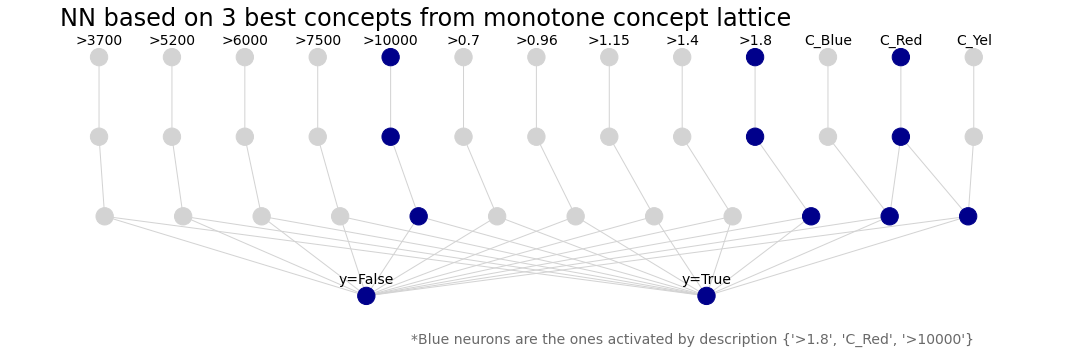

In [675]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 3 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now fit the network

In [682]:
cn.fit(X_train, y_train)


To obtain the prediction

In [683]:
import sklearn
sklearn.metrics.accuracy_score(y_test.values, cn.predict(X_test).numpy())

0.9875

In [688]:
cn.predict_proba(X_test)

tensor([[9.7050e-01, 2.9497e-02],
        [9.9396e-01, 6.0429e-03],
        [1.2688e-01, 8.7312e-01],
        [9.0941e-03, 9.9091e-01],
        [9.0941e-03, 9.9091e-01],
        [1.0616e-06, 1.0000e+00],
        [2.4030e-04, 9.9976e-01],
        [9.7050e-01, 2.9497e-02],
        [9.9396e-01, 6.0429e-03],
        [9.7050e-01, 2.9497e-02],
        [1.2001e-03, 9.9880e-01],
        [9.9920e-01, 7.9535e-04],
        [1.2001e-03, 9.9880e-01],
        [9.0941e-03, 9.9091e-01],
        [1.2001e-03, 9.9880e-01],
        [2.4030e-04, 9.9976e-01],
        [9.9396e-01, 6.0429e-03],
        [9.9396e-01, 6.0429e-03],
        [2.4030e-04, 9.9976e-01],
        [9.9396e-01, 6.0429e-03],
        [9.9396e-01, 6.0429e-03],
        [9.9396e-01, 6.0429e-03],
        [9.0941e-03, 9.9091e-01],
        [9.0941e-03, 9.9091e-01],
        [9.0941e-03, 9.9091e-01],
        [2.4030e-04, 9.9976e-01],
        [9.9396e-01, 6.0429e-03],
        [9.9920e-01, 7.9535e-04],
        [1.0842e-04, 9.9989e-01],
        [2.403

Let us look at the fitted weights of edges

In [661]:
edge_weights = cn.edge_weights_from_network()

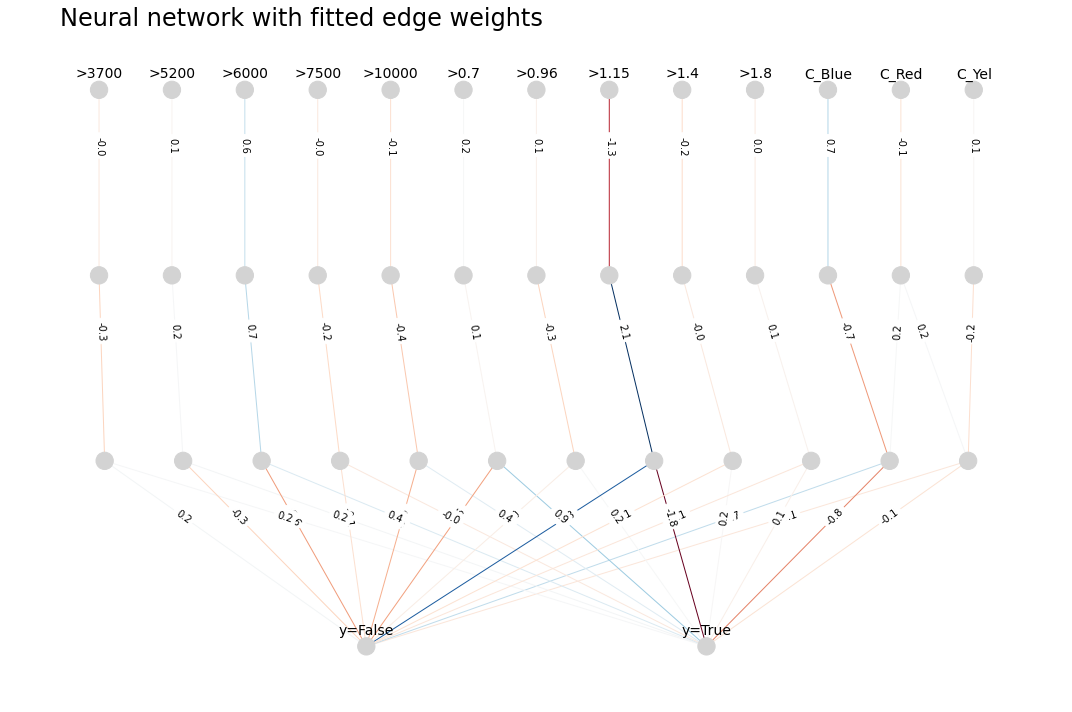

In [662]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,10))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

In [692]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [706]:
from sklearn.model_selection import KFold
metrics = {'fca_ac':[], 'fca_f1':[]}
kf = KFold(n_splits=5)
for train, test in kf.split(df_bin.drop(columns=['y']), df_bin['y']):
  X_tr = df_bin.drop(columns=['y']).iloc[train]
  y_tr = df_bin['y'][train]
  X_te = df_bin.drop(columns=['y']).iloc[train]
  y_te = df_bin['y'][train]  
  cn.fit(X_tr, y_tr)
  metrics['fca_f1'].append(sklearn.metrics.f1_score(y_te.values, cn.predict(X_te).numpy()))
  metrics['fca_ac'].append(sklearn.metrics.accuracy_score(y_te.values, cn.predict(X_te).numpy()))



In [715]:
from sklearn.linear_model import LogisticRegression

df_for_log = pd.concat([df[['Temperature', 'R']], Clr, Type], axis=1).rename(columns={0:'y'})

In [728]:
log_reg = LogisticRegression()
metrics['lreg_f1'] = []
metrics['lreg_ac'] = []
kf = KFold(n_splits=5)
for train, test in kf.split(df_for_log.drop(columns=['y']), df_for_log['y']):
  X_tr = df_bin.drop(columns=['y']).iloc[train]
  y_tr = df_bin['y'][train]
  X_te = df_bin.drop(columns=['y']).iloc[train]
  y_te = df_bin['y'][train]  
  log_reg.fit(X_tr, y_tr)
  metrics['lreg_f1'].append(sklearn.metrics.f1_score(y_te.values, log_reg.predict(X_te)))
  metrics['lreg_ac'].append(sklearn.metrics.accuracy_score(y_te.values, log_reg.predict(X_te)))

In [729]:
from sklearn.svm import SVC

clf =  SVC(kernel="linear", C=0.025)

metrics['scv_f1'] = []
metrics['svc_ac'] = []
kf = KFold(n_splits=5)
for train, test in kf.split(df_for_log.drop(columns=['y']), df_for_log['y']):
  X_tr = df_bin.drop(columns=['y']).iloc[train]
  y_tr = df_bin['y'][train]
  X_te = df_bin.drop(columns=['y']).iloc[train]
  y_te = df_bin['y'][train]  
  clf.fit(X_tr, y_tr)
  metrics['scv_f1'].append(sklearn.metrics.f1_score(y_te.values, clf.predict(X_te)))
  metrics['svc_ac'].append(sklearn.metrics.accuracy_score(y_te.values, clf.predict(X_te)))

In [733]:
from sklearn.tree import DecisionTreeClassifier

clf =  DecisionTreeClassifier(max_depth=2)
metrics['tree_f1'] = []
metrics['tree_ac'] = []
kf = KFold(n_splits=5)
for train, test in kf.split(df_for_log.drop(columns=['y']), df_for_log['y']):
  X_tr = df_bin.drop(columns=['y']).iloc[train]
  y_tr = df_bin['y'][train]
  X_te = df_bin.drop(columns=['y']).iloc[train]
  y_te = df_bin['y'][train]  
  clf.fit(X_tr, y_tr)
  metrics['tree_f1'].append(sklearn.metrics.f1_score(y_te.values, clf.predict(X_te)))
  metrics['tree_ac'].append(sklearn.metrics.accuracy_score(y_te.values, clf.predict(X_te)))

In [738]:
pd.DataFrame(pd.DataFrame.from_dict(metrics).mean())

,0
fca_ac,0.979167
fca_f1,0.977290
lreg_f1,1.000000
lreg_ac,1.000000
scv_f1,0.978336
svc_ac,0.979167
tree_f1,0.995839
tree_ac,0.995833
